In [1]:
import pandas as pd
import numpy as np
import scipy
from scipy import stats
import statsmodels as sm
import matplotlib
import matplotlib.pyplot as plt

matplotlib.style.use('ggplot')
matplotlib.rcParams['figure.figsize'] = (16.0, 12.0)

import warnings

%matplotlib inline

pd.options.display.max_columns = 80

In [2]:
trips = pd.read_csv('/home/data/fall_2018/HWtrips_032319.csv')

In [3]:
# can be manually specified instead
TOD_bounds = (trips.loc[:, ["TOD", "HW_trip_ET"]]
  .groupby("TOD")
  .agg(['min', 'max'])
  #.reset_index(inplace=True)
)
TOD_bounds.columns = TOD_bounds.columns.map('_'.join).str.strip(" _")
#TOD_bounds = TOD_bounds.rename(columns={"TOD_": "TOD"})
TOD_bounds


,HW_trip_ET_min,HW_trip_ET_max
TOD,,
0,3.166667,5.983333
1,6.000000,8.983333
2,9.000000,15.466667
3,15.500000,18.433333
4,0.016667,24.000000


In [4]:
dwell_bounds = (trips.loc[:, ["dwell_work", "work_dwell"]]
  .groupby("dwell_work")
  .agg(['min', 'max'])
  #.reset_index(inplace=True)
)
dwell_bounds.columns = dwell_bounds.columns.map('_'.join).str.strip(" _")
#dwell_bounds = dwell_bounds.rename(columns={"TOD_": "TOD"})
dwell_bounds

,work_dwell_min,work_dwell_max
dwell_work,,
1,0.016667,4.500000
2,4.500000,7.750000
3,7.750000,9.000000
4,9.000000,10.483333
5,10.500000,19.500000


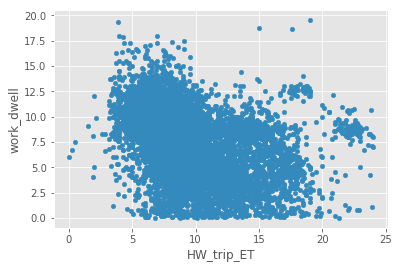

In [5]:
trips.plot.scatter(x='HW_trip_ET',
                   y='work_dwell')

In [6]:
f"Correlation between End Time and Dwell Time: {trips['HW_trip_ET'].corr(trips['work_dwell'])}"

## Given the correlation between HW_trip_ET and work_dwell time
## maybe it makes sense to draw them jointly from a multivariate distribution?

'Correlation between End Time and Dwell Time: -0.4067233807085886'

/home/lmwang/anaconda3/envs/template-env/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


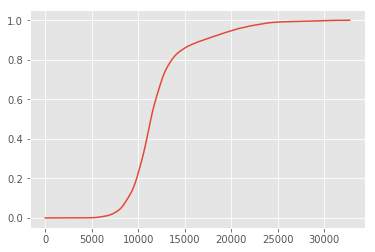

In [7]:
#import dfply as dp
#from dfply import >>
#import statsmodels.api as sm

#dens = sm.nonparametric.KDEUnivariate(trips["HW_trip_ET"])
#dens.fit()
#plt.plot(dens.cdf)
#plt.show()



In [8]:
def x_guassian_kde(group, x):
    data = group[[x]].values.T
    return stats.gaussian_kde(data)

def xy_guassian_kde2(group, x, y):
    data = group[[x, y]].values.T
    return stats.gaussian_kde(data)

ET_kde = (trips.loc[:, ["TOD", "HW_trip_ET"]]
          #.query("HW_trip_ET==HW_trip_ET") # filtering for NaN
  .groupby("TOD")
  .apply(lambda g: pd.Series({"kde": x_guassian_kde(g, x="HW_trip_ET")}))        
  #.apply(ST_guassian_kde)
  #.reset_index(name='kde')
)

ET_kde = ET_kde.join(TOD_bounds, on=["TOD"], lsuffix="_x")
#bounds.columns, ST_kde.columns
ET_kde
# Save ST_kde DataFrame for use in simulation


,kde,HW_trip_ET_min,HW_trip_ET_max
TOD,,,
0,<scipy.stats.kde.gaussian_kde object at 0x7f6b...,3.166667,5.983333
1,<scipy.stats.kde.gaussian_kde object at 0x7f6b...,6.000000,8.983333
2,<scipy.stats.kde.gaussian_kde object at 0x7f6b...,9.000000,15.466667
3,<scipy.stats.kde.gaussian_kde object at 0x7f6b...,15.500000,18.433333
4,<scipy.stats.kde.gaussian_kde object at 0x7f6b...,0.016667,24.000000


In [9]:
# work_dwell distribution
WD_kde = (trips.loc[:, ["dwell_work", "work_dwell"]]
          #.query("work_dwell==work_dwell") # filtering for NaN
  .groupby("dwell_work")
  .apply(lambda g: pd.Series({"kde": x_guassian_kde(g, x="work_dwell")}))        
  #.apply(ST_guassian_kde)
  #.reset_index(name='kde')
)

WD_kde = WD_kde.join(dwell_bounds, on=["dwell_work"], lsuffix="_x")
#bounds.columns, ST_kde.columns
WD_kde
# Save ST_kde DataFrame for use in simulation


,kde,work_dwell_min,work_dwell_max
dwell_work,,,
1,<scipy.stats.kde.gaussian_kde object at 0x7f6b...,0.016667,4.500000
2,<scipy.stats.kde.gaussian_kde object at 0x7f6b...,4.500000,7.750000
3,<scipy.stats.kde.gaussian_kde object at 0x7f6b...,7.750000,9.000000
4,<scipy.stats.kde.gaussian_kde object at 0x7f6b...,9.000000,10.483333
5,<scipy.stats.kde.gaussian_kde object at 0x7f6b...,10.500000,19.500000


In [ ]:
#from urbansim_templates import modelmanager
#modelmanager.initialize()

#modelmanager.register(m)

In [25]:
#ST_kde.loc[1, 'kde'].resample(2)
# In Simulation
n_by_TOD = (trips.groupby("TOD")
  .size()
  .reset_index(name='ntrips')
)

n_by_TOD = n_by_TOD.join(ET_kde, on="TOD")
         
n_by_TOD["HW_trip_ET"] = n_by_TOD.apply(lambda row: (row['kde'].resample(row['ntrips']))[0, ], axis=1)

#n_by_TOD["HW_trip_ST"] = n_by_TOD["ST"].apply(lambda x: x[0, ])
#n_by_TOD["WH_trip_ST"] = n_by_TOD["ST"].apply(lambda x: x[1, ])
#ST_kde.kde.apply(lambda x: x.resample(2))

trips_sim = pd.DataFrame({'TOD':n_by_TOD.TOD.repeat(n_by_TOD.HW_trip_ET.str.len()),
              'HW_trip_ET':np.concatenate(n_by_TOD.HW_trip_ET.values),
              #'WH_trip_ST':np.concatenate(n_by_TOD.WH_trip_ST.values),
             })

#trips_sim = trips_sim.set_index("TOD")
#n_by_TOD.ST.values[0, ][0, ].shape
#n_by_TOD["HW_trip_ST"].apply(lambda x: x.shape)

# To append trips_sim back to trip, sort both trips and trips_sim by TOD 
pd.concat([trips.sort_values(by="TOD"), 
           (trips_sim.sort_values(by="TOD")
            .rename(columns={"HW_trip_ET": "HW_trip_ET_sim"})
            .loc[:, "HW_trip_ET_sim"])], axis=0)
#trips_sim.shape

# handle 24+ hour
#trips_sim.loc[trips_sim["TOD"].isin([14.0, 24.0]) & (trips_sim.WH_trip_ST < 12), 'WH_trip_ST'] -= 24

,Unnamed: 0,HHPER,index,Unnamed: 0.1,HHPERTRIP,origin,home_dwell,home_ST,HW_trip_ST,HW_trip_ET,HW_TT,HW_mode,work_dwell,work_ST,WH_trip_ST,WH_trip_ET,WH_TT,WH_mode,TOD,dwell_work,SAMPN,PERNO,GEND,AGE,HISP,RACE1,RACE2,RACE3,RACE4,HOURS,EDUCA,INDUS,HHVEH,OWN,INCOM,HHSIZ,minority,black,native,asian,PI,hh_inc_less75k,hh_inc_75kless100k,hh_inc_150kplus,hh_inc_150kless250k,hh_inc_250kplus,lessGED,GED,someBach,Assoc,Bach,lessGED_GED,no_higher_ed,age_16less25,age_25less40,age_40less50,age_50less60,female,tenure_2,noveh,hh_size_1per,sector_constr,sector_mfg,sector_retail,sector_transport,info,finance,scitech,sector_edu_serv,sector_healthcare,sector_oth_serv,sector_gov,TOD_3to6,TOD_9to1530,TOD_1530to1830,TOD_1830up,0
4832,4832.0,16798401.0,11319.0,11705.0,1.679840e+09,home,13.250000,15.916667,5.166667,5.416667,0.250000,drive_alone,9.833333,5.416667,15.250000,15.916667,0.666667,drive_alone,0.0,4.0,1679840.0,1.0,1.0,43.0,1.0,97.0,NaN,NaN,NaN,40.0,2.0,31.0,1.0,2.0,4.0,3.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,NaN
6405,6405.0,17898201.0,14974.0,15491.0,1.789820e+09,home,10.816667,16.283333,3.100000,3.566667,0.466667,drive_alone,11.200000,3.566667,14.766667,16.283333,1.516667,drive_alone,0.0,5.0,1789820.0,1.0,1.0,58.0,0.0,1.0,NaN,NaN,NaN,40.0,5.0,71.0,4.0,1.0,7.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,NaN
6407,6407.0,17898203.0,14978.0,15495.0,1.789820e+09,home,11.166667,16.833333,4.000000,5.083333,1.083333,drive_alone,9.250000,5.083333,14.333333,16.833333,2.500000,drive_alone,0.0,4.0,1789820.0,3.0,1.0,32.0,0.0,1.0,NaN,NaN,NaN,40.0,5.0,72.0,4.0,1.0,7.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,NaN
6408,6408.0,17898711.0,14980.0,15497.0,1.789871e+09,home,10.666667,17.333333,4.000000,5.500000,1.500000,drive_alone,10.000000,5.500000,15.500000,17.333333,1.833333,drive_alone,0.0,4.0,1789871.0,1.0,1.0,50.0,1.0,97.0,NaN,NaN,NaN,49.0,1.0,11.0,1.0,1.0,2.0,6.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,NaN
3196,3196.0,14561581.0,7542.0,7804.0,1.456158e+09,home,12.500000,15.750000,4.250000,4.466667,0.216667,drive_alone,11.033333,4.466667,15.500000,15.750000,0.250000,drive_alone,0.0,5.0,1456158.0,1.0,1.0,54.0,0.0,1.0,NaN,NaN,NaN,40.0,4.0,31.0,1.0,1.0,6.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,NaN
9099,9099.0,19621652.0,21113.0,21860.0,1.962165e+09,home,14.583333,14.750000,5.333333,5.616667,0.283333,drive_alone,8.966667,5.616667,14.583333,14.750000,0.166667,drive_alone,0.0,3.0,1962165.0,2.0,1.0,53.0,0.0,1.0,NaN,NaN,NaN,40.0,4.0,61.0,2.0,1.0,6.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,NaN
4916,4916.0,16852002.0,11528.0,11922.0,1.685200e+09,home,11.866667,17.050000,4.916667,5.700000,0.783333,drive_alone,10.300000,5.700000,16.000000,17.050000,1.050000,drive_alone,0.0,4.0,1685200.0,2.0,2.0,53.0,0.0,4.0,NaN,NaN,NaN,40.0,4.0,31.0,2.0,2.0,3.0,4.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,NaN
11179,11179.0,25130812.0,25970.0,26913.0,2.513081e+09,home,13.083333,15.416667,4.500000,4.916667,0.416667,drive_alone,10.083333,4.916667,15.000000,15.416667,0.416667,drive_alone,0.0,4.0,2513081.0,2.0,1.0,59.0,0.0,1.0,NaN,NaN,NaN,45.0,2.0,48.0,2.0,1.0,5.0,3.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,

In [ ]:
def simulate_from_kde(n_by_group, a_kde, group_name, x_name):
    n_by_group = n_by_group.join(a_kde, on=group_name)

    n_by_group[x_name] = n_by_group.apply(lambda row: row['kde'].resample(row['ntrips']), axis=1)

    #n_by_group["HW_trip_ST"] = n_by_group["ST"].apply(lambda x: x[0, ])
    #n_by_group["WH_trip_ST"] = n_by_group["ST"].apply(lambda x: x[1, ])
    #a_kde.kde.apply(lambda x: x.resample(2))

    samples = pd.DataFrame({group_name: n_by_group[group_name].repeat(n_by_group.sample.str.len()),
                            x_name: np.concatenate(n_by_group.sample.values),
                          })
    samples = samples.reset_index()
    #print(samples.index)

    #trips_sim = trips_sim.set_index("TOD")
    #n_by_group.ST.values[0, ][0, ].shape
    #n_by_group["HW_trip_ST"].apply(lambda x: x.shape)

    # handle 24+ hour
    #samples.loc[samples["TOD"].isin([14.0, 24.0]) & (samples.WH_trip_ST < 12), 'WH_trip_ST'] -= 24
    
    samples_w_bounds = samples.join(a_kde, how="left", on=group_name)
    samples_w_bounds.reset_index()
    
    samples_good = (samples_w_bounds.query(f'({x_name}_min <= {x_name} <= {x_name}_max) and ' +
                                           f'({x_name}_min <= {x_name} <= {x_name}_max )')
                                    .loc[:, [group_name, x_name]]
                   )
                         
    _n_by_group = (samples.loc[~samples.index.isin(samples_good.index)]
                        .groupby(group_name)
                        .size()
                        .reset_index(name='ntrips'))
    
    #print(samples.index)
    #print(samples_good.index)
    print("There are {} samples with out of bounds values".format(_n_by_group.ntrips.sum()))
    if _n_by_group.shape[0] > 0:
        samples_extra = simulate_from_kde(_n_by_group, a_kde, group_name, x_name)
        samples = pd.concat([samples_good, samples_extra], sort=False)
            
    return samples

In [ ]:
n_by_TOD = (trips.groupby("TOD")
  .size()
  .reset_index(name='ntrips')
)

n_by_TOD.columns, ET_kde.columns
trips_sim = simulate_from_kde(n_by_TOD, ET_kde, group_name="TOD", x_name="HW_trips_ET")
#trips_sim.loc[trips_sim["TOD"].isin([14.0, 24.0]) & (trips_sim.WH_trip_ST < 12), 'WH_trip_ST'] -= 24

In [ ]:
assert np.alltrue( 
    n_by_TOD == (trips_sim.groupby("TOD")
                 .size()
                 .reset_index(name='ntrips')
                )
)
#trips_sim.columns, bounds.columns

In [ ]:
# check for samples out of bounds
(
trips_sim.join(bounds, on="TOD")
    .query('(HW_trip_ST < HW_trip_ST_min) or ' +
                '(HW_trip_ST > HW_trip_ST_max) or ' +  
                '(WH_trip_ST < WH_trip_ST_min) or ' +
                '(WH_trip_ST > WH_trip_ST_max)')
)

In [ ]:
trips_sim.plot.scatter(x='HW_trip_ST',
                       y='WH_trip_ST',
                       c=trips_sim.TOD.apply(lambda x: colors[x]))